In [5]:
import csv
import math
import string
import unicodedata

from collections import Counter

import nltk

import matplotlib.pyplot as plt

from cltk.stops.grc import STOPS
from cltk import NLP
from cltk.alphabet.processes import GreekNormalizeProcess

from ajax_odysseus_speech_analysis.group_speeches import AjaxDocument

In [6]:
DOC = AjaxDocument()
GREEK_STOPS = [unicodedata.normalize('NFC', s) for s in STOPS]
ajax = 'Αἴας'
odysseus = 'Ὀδυσσεύς'

‎𐤀 CLTK version '1.1.6'.
Pipeline for language 'Ancient Greek' (ISO: 'grc'): `GreekNormalizeProcess`, `GreekStanzaProcess`, `GreekEmbeddingsProcess`, `StopsProcess`.


In [7]:
speeches = DOC.group_lines()

In [8]:
def docify_lines(speaker):
    lines = speeches[speaker]
    docified_lines = []
    
    for l in lines:
        docified_lines.append(l[1])
    
    return "\n".join(docified_lines)

def clean_string(s):
    return s.strip(string.punctuation)

def lemmata(speaker):
    lines = docify_lines(speaker)
    analyzed_lines = DOC.nlp.analyze(lines)
    
    return [clean_string(w.lemma) for w in analyzed_lines if clean_string(w.lemma) not in GREEK_STOPS]

In [9]:
def calculate_tf(term, doc):
    counts = Counter(doc)
    total_terms = sum([count for t, count in counts.items()])
    return counts.get(term) / total_terms

In [10]:
def calculate_idf(term, docs):
    n = len(docs)
    d = 1 + sum([1 for d in docs if term in d])
    
    return math.log(n / d, 2)

In [11]:
all_speaker_lemmata = dict([(speaker, lemmata(speaker)) for speaker, _lines in speeches.items()])

In [12]:
speaker_docs = [ls for _s, ls in all_speaker_lemmata.items()]

In [13]:
def tf_idf_for_speaker(speaker):
    speaker_lemmata = all_speaker_lemmata[speaker]
    speaker_tfs = [(term, calculate_tf(term, speaker_lemmata)) for term in set(speaker_lemmata)]
    speaker_idfs = [(term, calculate_idf(term, speaker_docs)) for term in set(speaker_lemmata)]
    
    tf_idfs = []
    for (term, tf) in speaker_tfs:
        idf = next(idf for (t, idf) in speaker_idfs if t == term)
        tf_idfs.append((term, tf*idf))
    
    return dict(tf_idfs)

In [14]:
tf_idfs = dict([(speaker, tf_idf_for_speaker(speaker)) for speaker, _lines in speeches.items()])

In [15]:
def create_ngrams(word_list, n):
    ngrams = []
 
    for num in range(0, len(word_list)):
        ngram = tuple(word_list[num:num + n])
        ngrams.append(ngram)
 
    return ngrams

def score_ngram(ngram, weights, max_score):
    scores = [weights.get(s, 0) for s in ngram]
    
    return (sum(scores) / len(scores)) / max_score

def compare_speakers_with_trigrams(speaker_a, speaker_b):
    speaker_a_lemmata = all_speaker_lemmata[speaker_a]
    speaker_a_trigrams = nltk.trigrams(speaker_a_lemmata)
    speaker_b_tf_idf = tf_idfs[speaker_b]
    
    scored_trigrams = [score_ngram(trigram, speaker_b_tf_idf) for trigram in speaker_a_trigrams]
    
    return scored_trigrams

In [39]:
def compare_speakers_with_unigrams(speaker_a, speaker_b):
    speaker_a_lemmata = all_speaker_lemmata[speaker_a]
    speaker_b_tf_idf = tf_idfs[speaker_b]
    
    return [speaker_b_tf_idf.get(l, 0) for l in speaker_a_lemmata]

def compare_speakers_with_ngrams(speaker_a, speaker_b, n):
    speaker_a_lemmata = all_speaker_lemmata[speaker_a]
    speaker_a_ngrams = create_ngrams(speaker_a_lemmata, n)
    speaker_b_tf_idf = tf_idfs[speaker_b]
    max_tf_idf = speaker_b_tf_idf[max(speaker_b_tf_idf, key=speaker_b_tf_idf.get)]
    
    scored_ngrams = [score_ngram(ngram, speaker_b_tf_idf, max_tf_idf) for ngram in speaker_a_ngrams]
    
    return (speaker_a_ngrams, scored_ngrams)

In [54]:
def plot_comparison(speaker_a, speaker_b, n=4):
    speaker_a_ngrams, scores = compare_speakers_with_ngrams(speaker_a, speaker_b, n)
    ngram_score_dict = dict(zip(speaker_a_ngrams, scores))
    x_axis = range(0, len(scores))
    fig, ax = plt.subplots()
    fig.suptitle("{} compared to {} by {}s".format(speaker_a, speaker_b, n))
    high_score_key = max(ngram_score_dict, key=ngram_score_dict.get)
    ax.annotate(" ".join(high_score_key), xy=(speaker_a_ngrams.index(high_score_key), ngram_score_dict[high_score_key]))
    ax.plot(x_axis, scores)
    plt.ylim([0, 0.6])
    plt.show()

In [41]:
import itertools

In [42]:
pairs = itertools.permutations([s for s, _l in tf_idfs.items()], 2)
only_main_actors = ['Αἴας', 'Ὀδυσσεύς', 'Τεῦκρος', 'Μενέλαος', 'Ἀγαμέμνων', 'Τέκμησσα', 'Ἀθήνα']
pairs = [p for p in pairs if p[0] in only_main_actors and p[1] in only_main_actors]

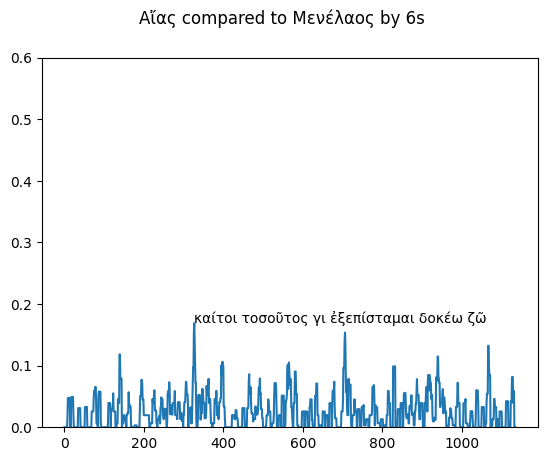

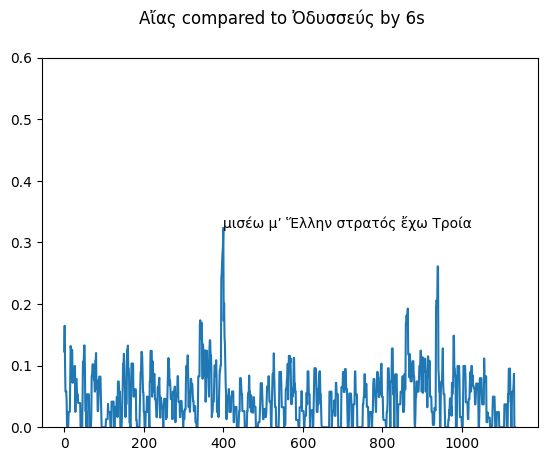

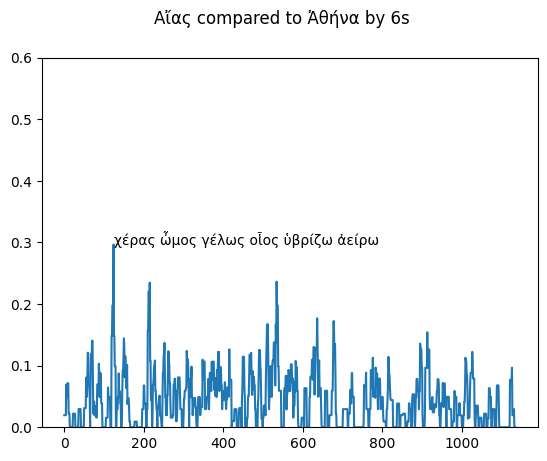

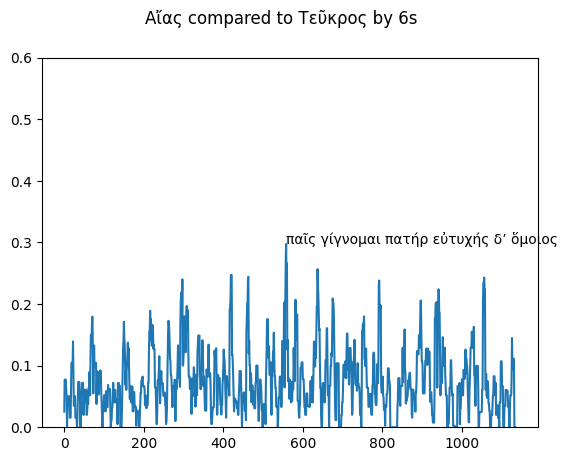

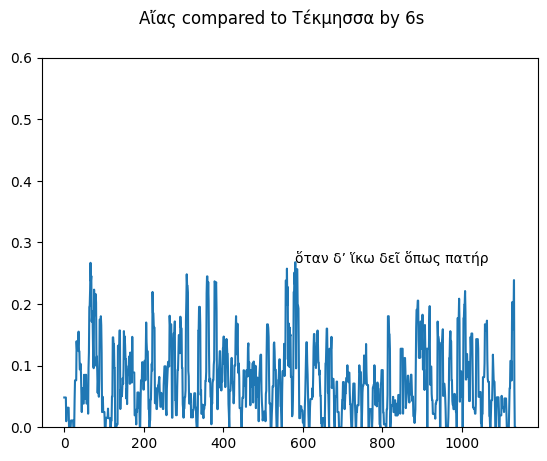

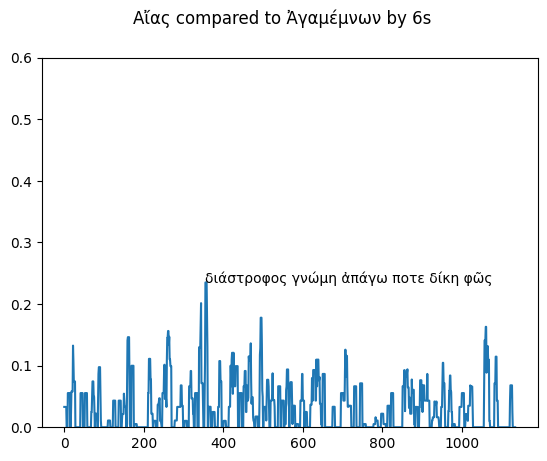

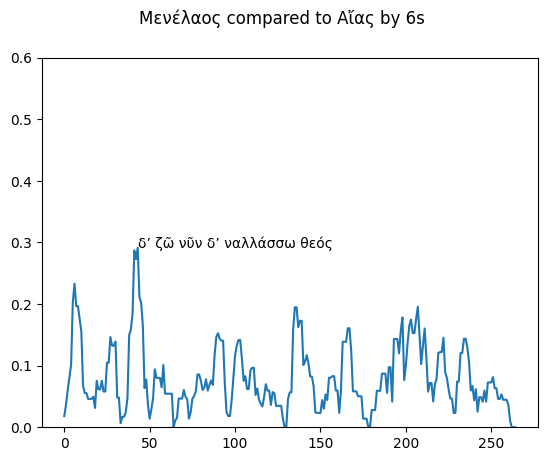

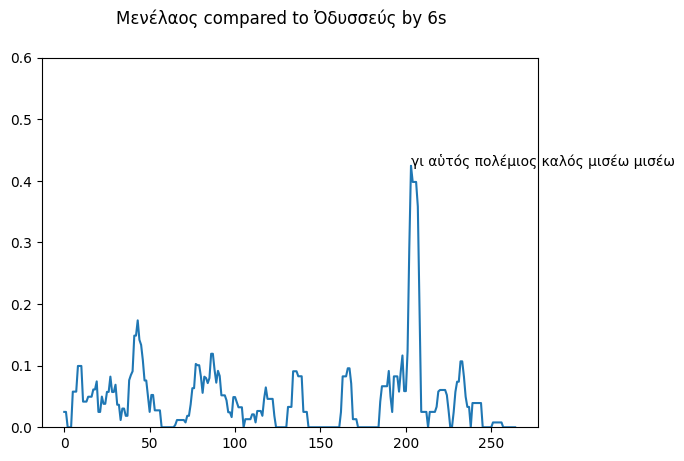

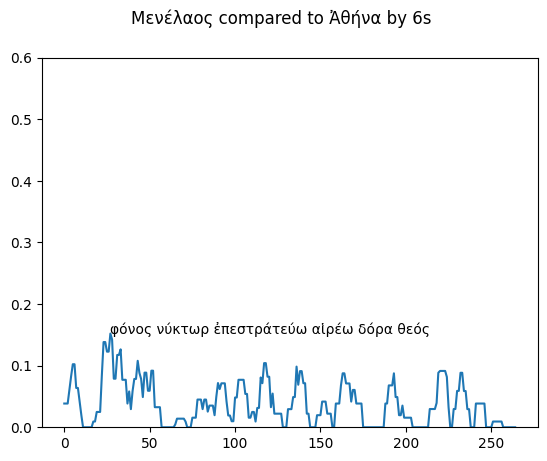

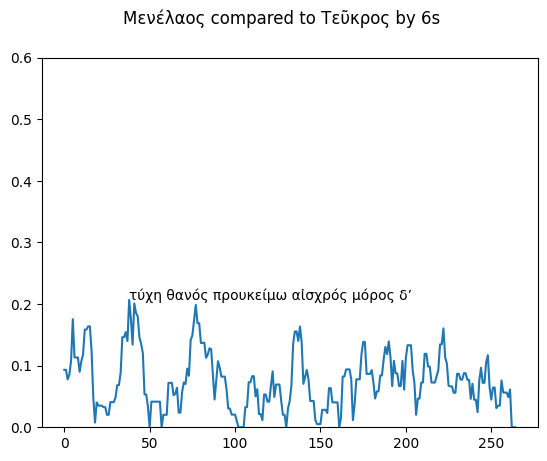

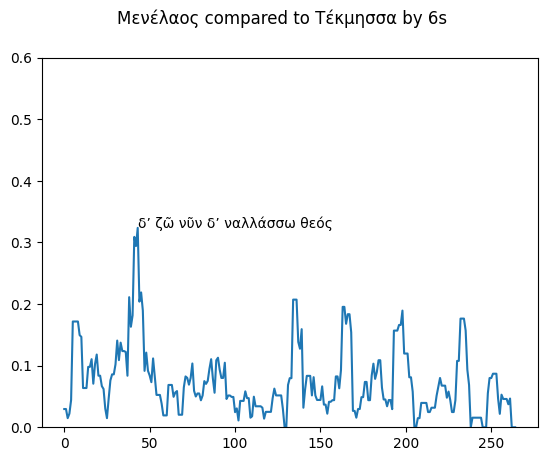

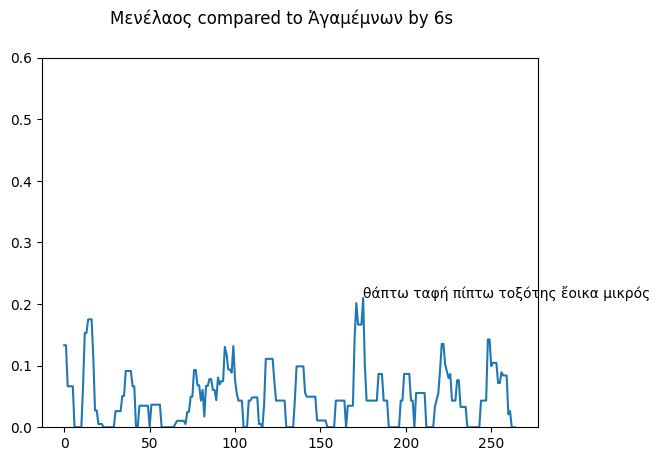

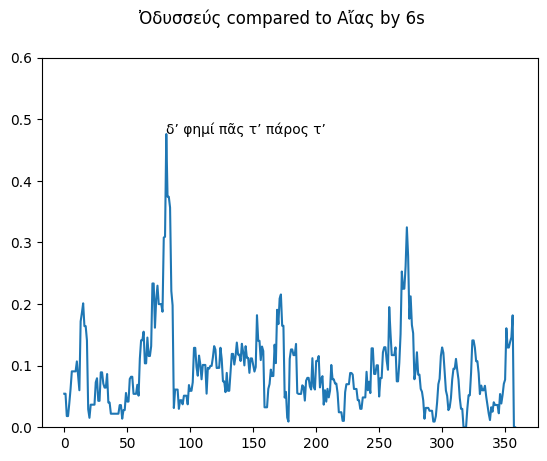

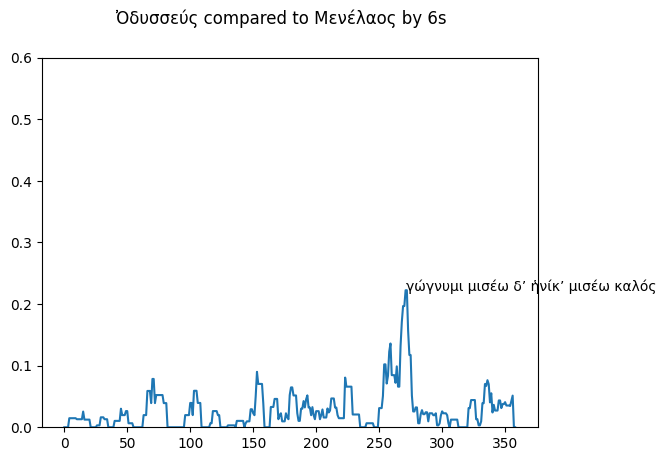

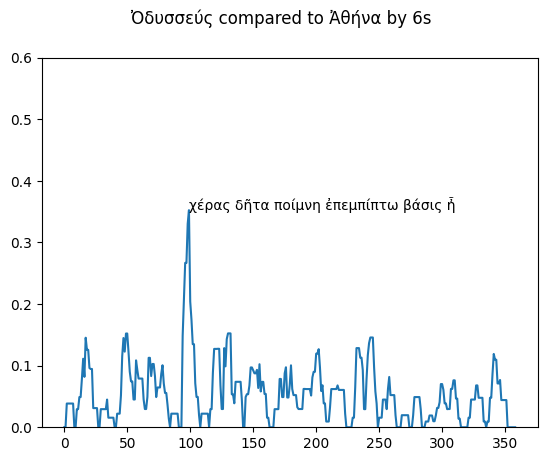

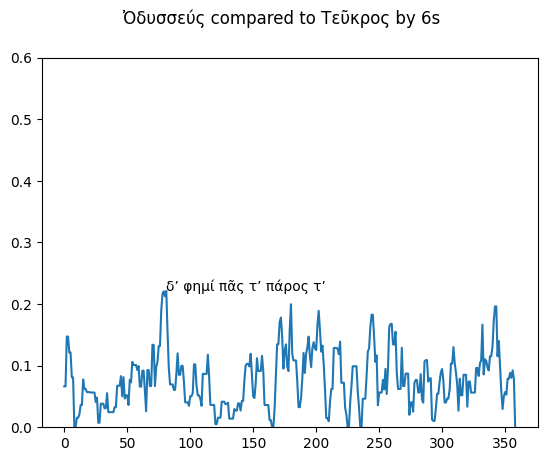

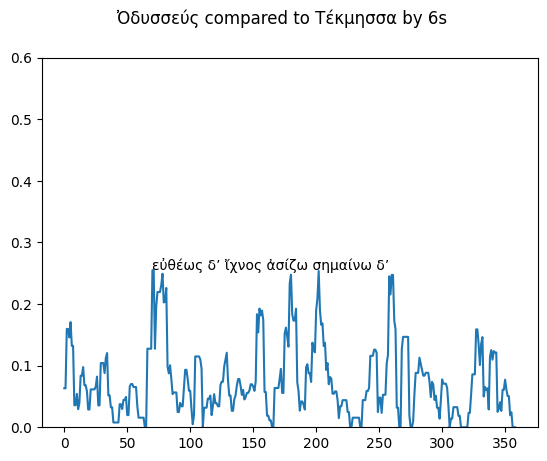

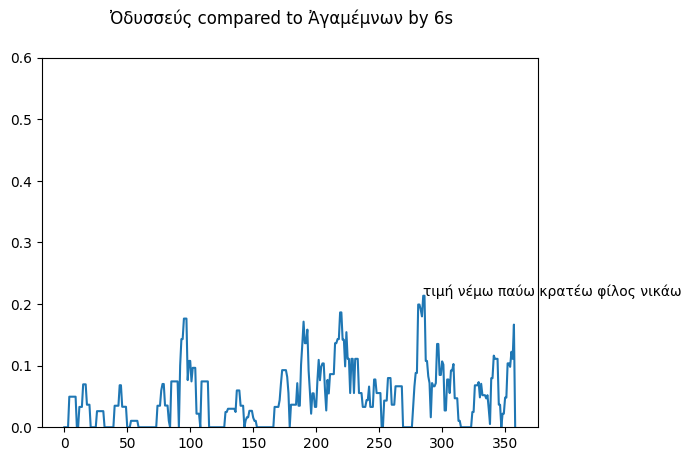

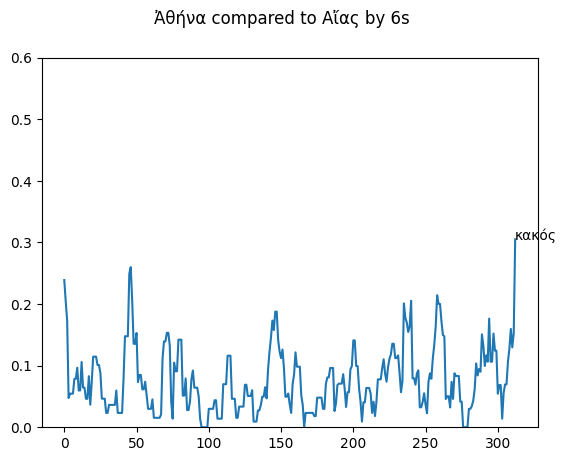

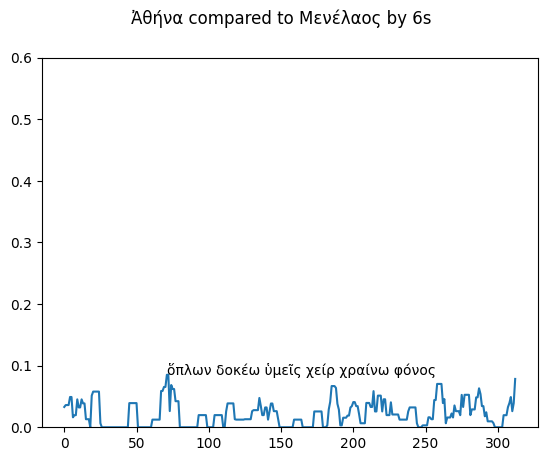

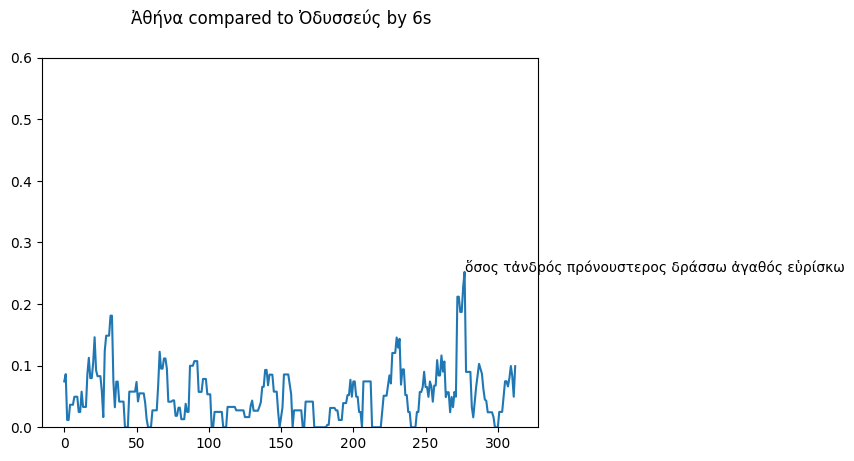

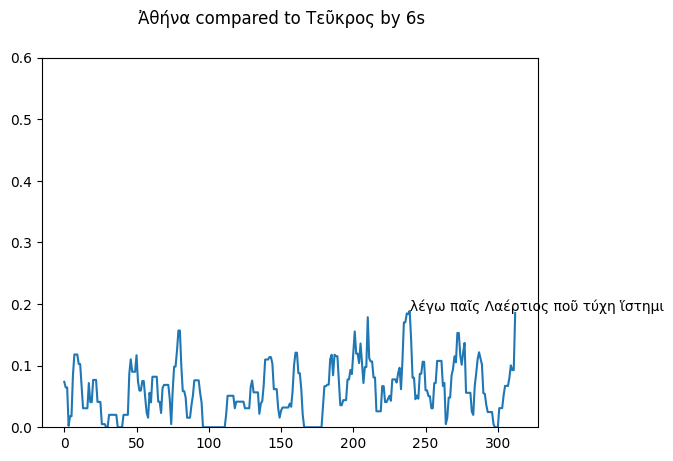

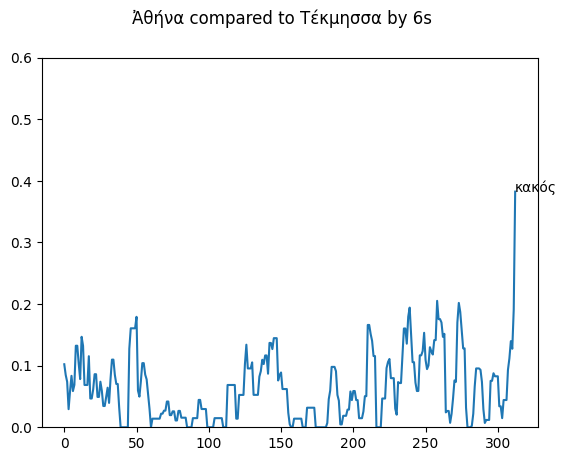

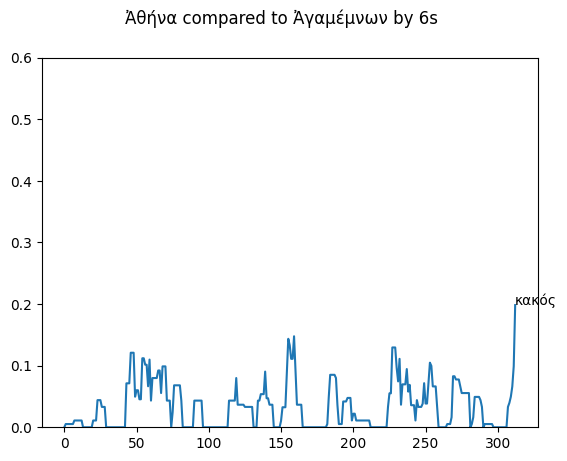

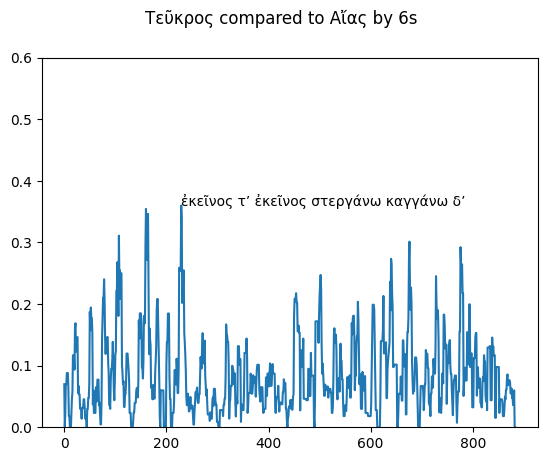

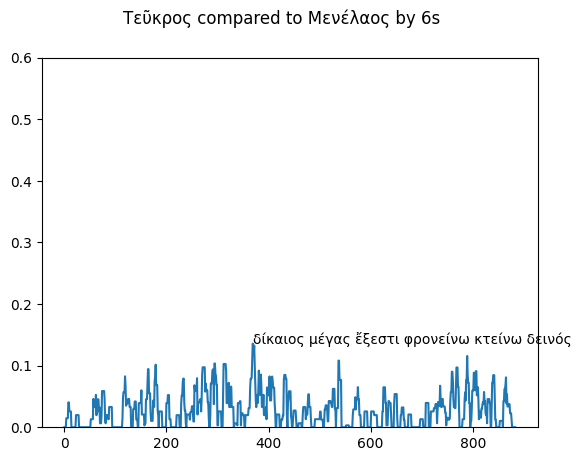

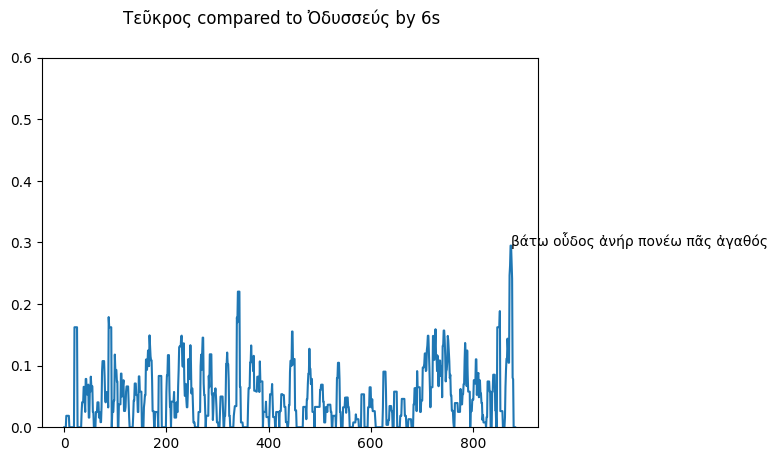

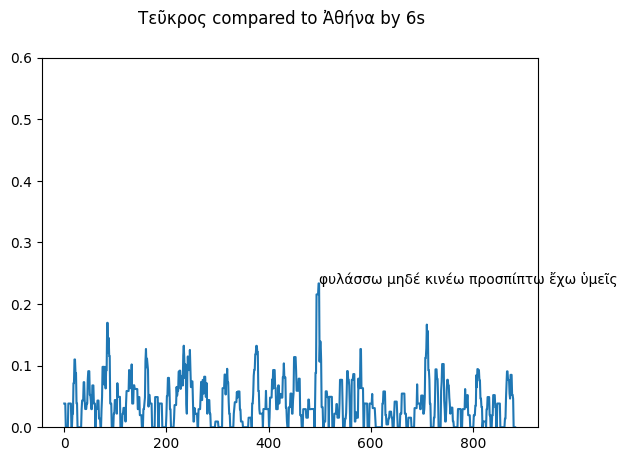

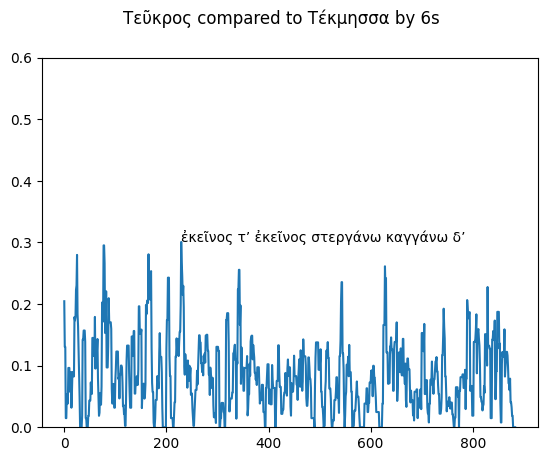

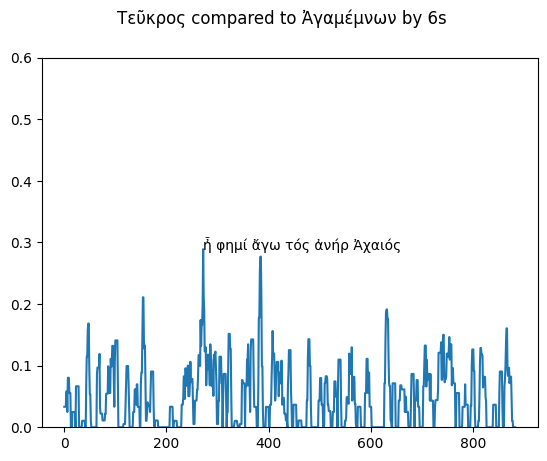

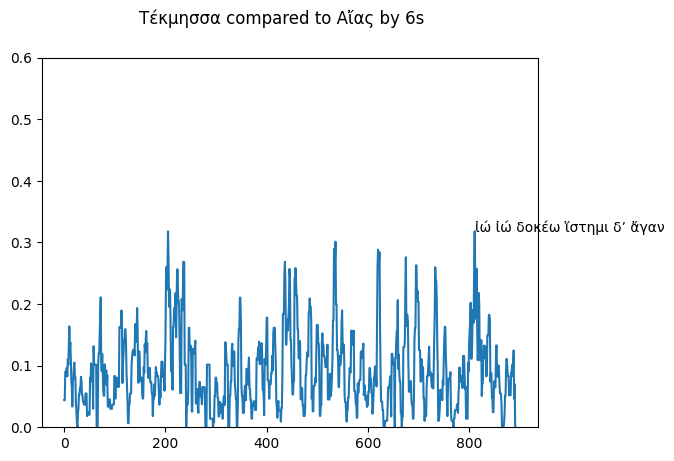

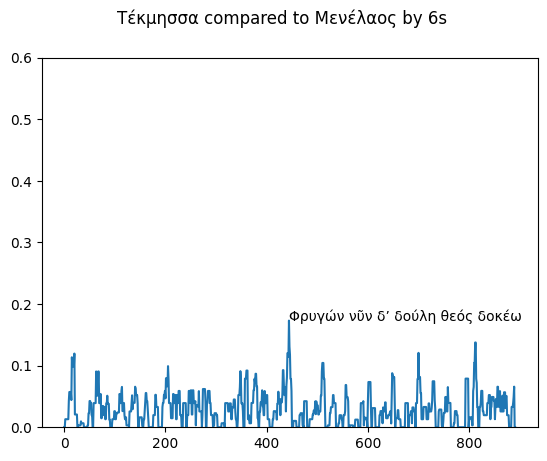

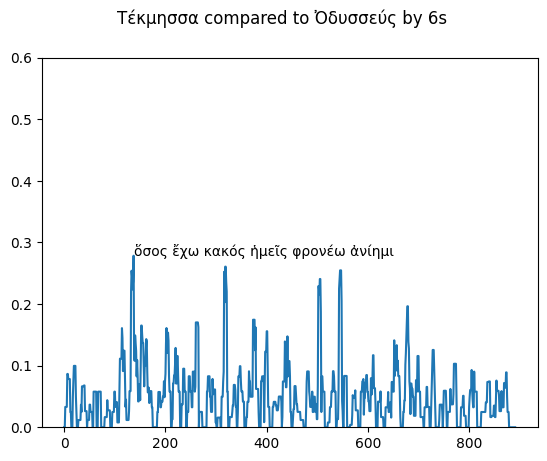

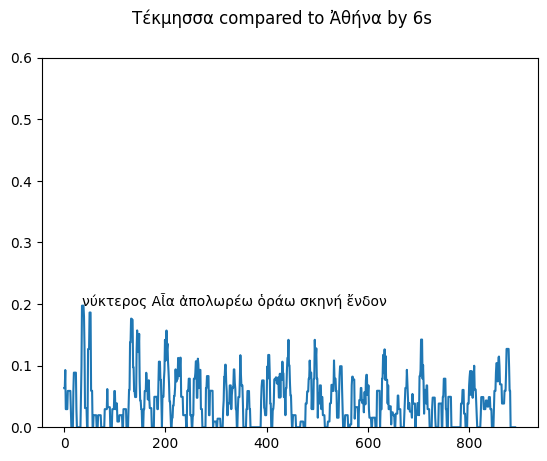

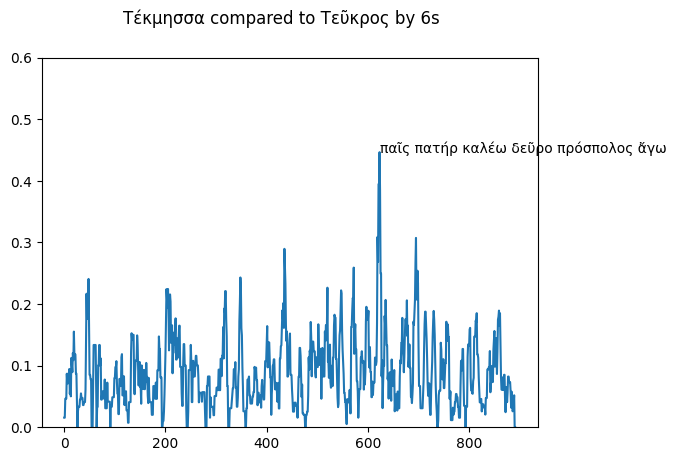

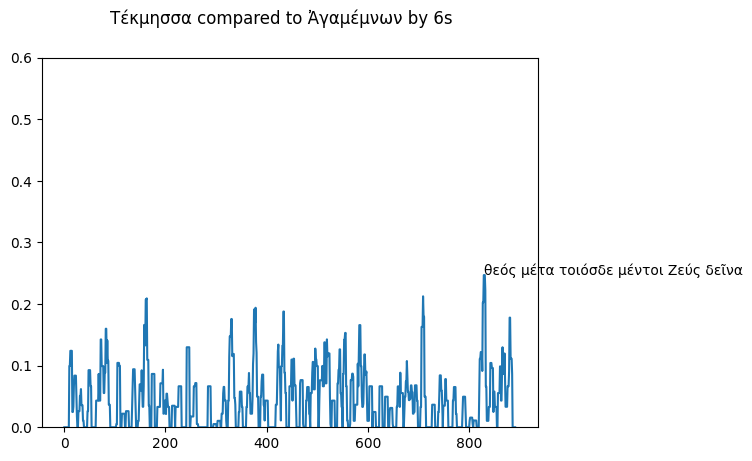

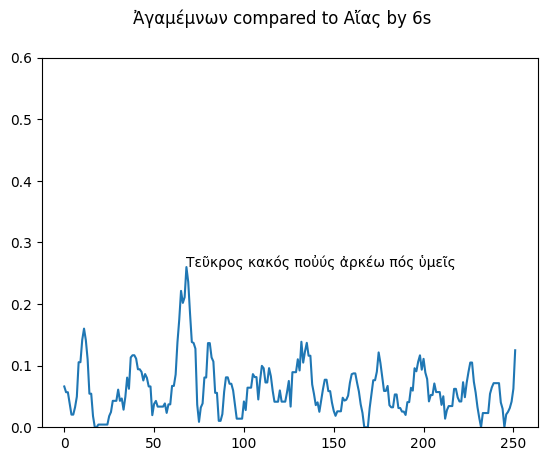

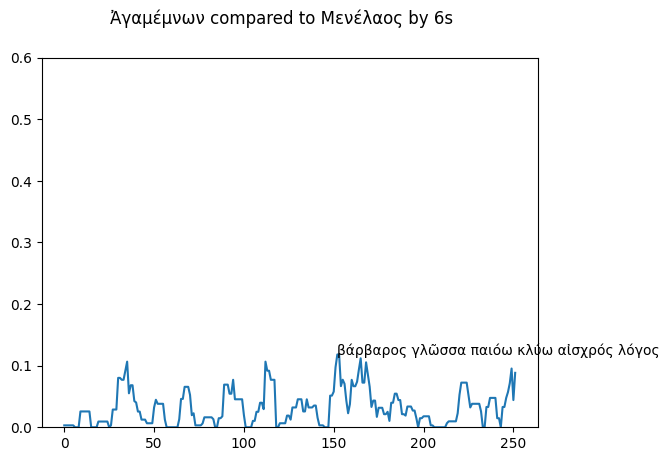

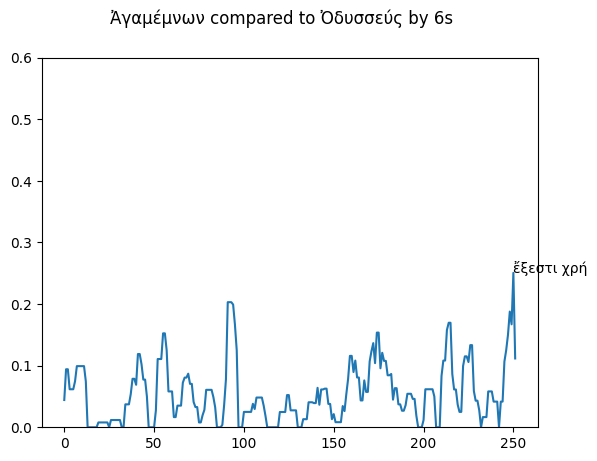

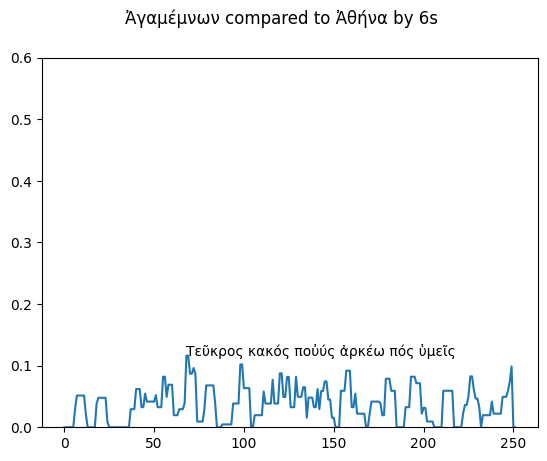

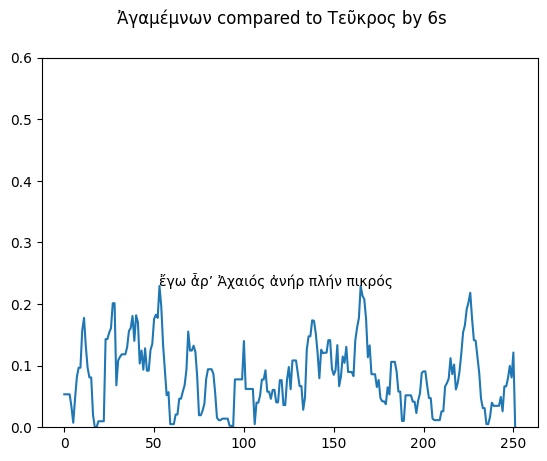

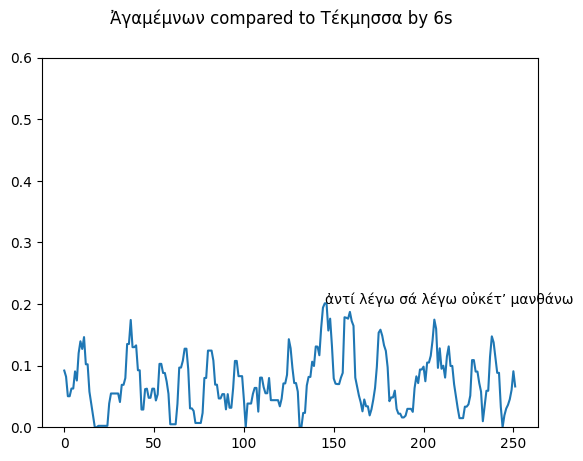

In [59]:
for pair in pairs:
    plot_comparison(pair[0], pair[1], 6)